# <center> Locked Supply Optimization Algorithm </center>

Extends the work from the paper - https://people.eecs.berkeley.edu/~ksk/files/Ohm_Liquidity_Management.pdf

https://mirror.xyz/evandekim.eth/Q2tdbKQjTyrSixC4YaElqr83zJE0gUIOIzltxFa-VIQ

In [ ]:
import pandas as pd
import random
import matplotlib.pyplot as plt

In [ ]:
class BondMachineSim:
  '''
    There are 4 initialization variables:
      POLICY VARIABLES:
        lock_rate = lock ratio between unlocked and locked supply
        growth_rate = growth ratio between current and expected circulating supply
      MARKET VARIABLES:
        initial_supply_circ = unlocked CNV not in LP
        initial_supply_lp = CNV unlocked supply in LP
    The smart bond algorithm operates in the following way:
      1) Get current state.
      2) Get expected state (based off of current state).
      3) Get transition state by calculating the deltas between current state and expected state
      4) Shift incentives (micro smart contract variables) accordingly to push system towards expected state (This part has to wait until bonding architecture is finalized)
      5) Rinse and Repeat

     - Expected methods are the target supply levels we want.
     - Delta methods calculates the transition state.
  '''
  def __init__(
      self, 
      lock_rate,
      growth_rate,
      initial_supply_circ,
      initial_supply_lp
      ):

    # policy variables
    self.lock_rate = lock_rate
    self.growth_rate = growth_rate
    self.lp_rate = 1 - lock_rate

    # current state 
    self.supply_circ = initial_supply_circ + initial_supply_lp
    self.supply_lp = initial_supply_lp
    self.debt_supply = 0
    self.locked_supply = 0

    # expected state 
    self.supply_circ_exp = 0
    self.supply_lp_exp = 0
    self.debt_supply_exp = 0
    self.locked_supply_exp = 0

    # transition state 
    self.supply_circ_delta = 0
    self.supply_lp_delta = 0
    self.debt_supply_delta = 0
    self.locked_supply_delta = 0

    # data storage
    self.data_policy_variables =  {"lock_rate": [self.lock_rate], "growth_rate": [self.growth_rate], "lp_rate": [self.lp_rate]}
    self.data_current_state = {"supply_circ": [self.supply_circ], "supply_lp": [self.supply_lp], "debt_supply": [self.debt_supply], "locked_supply": [self.locked_supply]}
    self.data_expected_state = {"supply_circ_exp": [], "supply_lp_exp": [], "debt_supply_exp": [], "locked_supply_exp": []}
    self.data_transition_state = {"supply_lp_delta": [], "debt_supply_delta": [], "locked_supply_delta": []}


 
  def setSupplyCircExp(self):
    '''
      Sets expected circulating supply
    '''
    # self.supply_circ_exp = self.supply_circ * self.growth_rate
    # self.supply_circ_exp = self.supply_circ + self.debt_supply + self.locked_supply


    # 3/9/22 Note - to properly define expected supply, we need better forecasting tools on how many bonds we
    # EXPECT to sell. Currently not feasible for simulation purposes right now. Can implement later with Step 4
    self.supply_circ_exp = self.supply_circ

  def setLPExp(self):
    '''
      Sets expected lp supply.
    '''
    self.supply_lp_exp = self.supply_circ * self.lp_rate  # should be lp rate

  def setDebtExp(self):
    '''
      Sets expected debt. 

      expected debt is defined as amount of expected supply that is ready to be issued, 
      but has not yet been issued. 
    '''
    self.debt_supply_exp = self.supply_circ * self.growth_rate
  
  def setLockedExp(self):
    '''
      Sets expected locked supply. 

      expected locked supply is the amount of supply we want in locked staking bonds. 
    '''
    self.locked_supply_exp = self.supply_circ * self.lock_rate
    
  def calcSupplyCircDelta(self):
    self.supply_circ_delta = self.supply_circ_exp - self.supply_circ

  def calcLpDelta(self):
    '''
    Interally calculate difference between current and expected LP supply. This 
    measures levels of liquidity.
    '''
    self.supply_lp_delta = self.supply_lp_exp - self.supply_lp

  def calcDebtDelta(self):
    '''
      Calculate difference between current and expected debt. This measures
      macro market demand for bonding.
    '''
    self.debt_supply_delta = self.debt_supply_exp - self.debt_supply
  
  def calcLockedDelta(self):
    '''
      Calculate difference between current and expected locked supply.
      This measures market demand for locked staking.
    '''
    self.locked_supply_delta = self.locked_supply_exp - self.locked_supply


  # initialize sim, important function! put in different place?
  def InitializeSim(self):
    '''
      Call this method first to initialize the variables in data_expected_state dict.
    '''
    # expected state
    self.setSupplyCircExp()
    self.setLPExp()
    self.setDebtExp()
    self.setLockedExp()
    # transition state
    self.calcSupplyCircDelta()
    self.calcLpDelta()
    self.calcDebtDelta()
    self.calcLockedDelta()
    # update expected state
    self.data_expected_state["supply_circ_exp"].append(self.supply_circ_exp)
    self.data_expected_state["supply_lp_exp"].append(self.supply_lp_exp)
    self.data_expected_state["debt_supply_exp"].append(self.debt_supply_exp)
    self.data_expected_state["locked_supply_exp"].append(self.locked_supply_exp)
    # update transition state
    self.data_transition_state["supply_lp_delta"].append(self.supply_lp_delta)
    self.data_transition_state["debt_supply_delta"].append(self.debt_supply_delta)
    self.data_transition_state["locked_supply_delta"].append(self.locked_supply_delta)

  def runSim(self, steps):
    '''
      Sim Improvement Notes:
      - Create a lock/unlock queue to make supply release more realistic.
    '''
    for i in range(steps):
      # calculate new current values based off of previous transition state
      lp_bought = self.data_transition_state["supply_lp_delta"][i] * random.uniform(0,1)
      debt_bought = self.data_transition_state["debt_supply_delta"][i] * random.uniform(0, 1)
      supply_locked = self.data_transition_state["locked_supply_delta"][i] * random.uniform(0,1)
      # calculate current state
      self.supply_circ = self.supply_circ + debt_bought + lp_bought
      self.supply_lp += lp_bought
      self.debt_supply += self.debt_supply_delta
      self.locked_supply += supply_locked
      # update current state
      self.data_current_state["supply_circ"].append(self.supply_circ)
      self.data_current_state["supply_lp"].append(self.supply_lp)
      self.data_current_state["debt_supply"].append(self.debt_supply)
      self.data_current_state["locked_supply"].append(self.locked_supply)
      # calculate expected state
      self.setSupplyCircExp()
      self.setLPExp()
      self.setDebtExp()
      self.setLockedExp()
      # update expected state
      self.data_expected_state["supply_circ_exp"].append(self.supply_circ_exp)
      self.data_expected_state["supply_lp_exp"].append(self.supply_lp_exp)
      self.data_expected_state["debt_supply_exp"].append(self.debt_supply_exp)
      self.data_expected_state["locked_supply_exp"].append(self.locked_supply_exp)
      # calculate transition state
      self.calcSupplyCircDelta()
      self.calcLpDelta()
      self.calcDebtDelta()
      self.calcLockedDelta()
      # update transition state
      self.data_transition_state["supply_lp_delta"].append(self.supply_lp_delta)
      self.data_transition_state["debt_supply_delta"].append(self.debt_supply_delta)
      self.data_transition_state["locked_supply_delta"].append(self.locked_supply_delta)



In [ ]:
# There are 4 initialization variables:
#   POLICY VARIABLES (invariants):
#     lock_rate = lock ratio between unlocked and locked supply
#     growth_rate = growth ratio between current and expected circulating supply
#   MARKET VARIABLES:
#     initial_supply_circ = unlocked CNV not in LP
#     initial_supply_lp = CNV unlocked supply in LP


# policy variables (invariants)
lock_rate = .9
growth_rate = 2

# current state variables
initial_supply_circ = 17e4
initial_supply_lp = 15e3

In [ ]:
# 1) initialize bond machine and get current state + expected state
bondSim = BondMachineSim(
    lock_rate,
    growth_rate,
    initial_supply_circ,
    initial_supply_lp
    )


In [ ]:
# initialize simulation values
bondSim.InitializeSim()

# show starting states
print(f"current state: {bondSim.data_current_state}")
print(f"expected state: {bondSim.data_expected_state}")
print(f"transition state: {bondSim.data_transition_state}")

current state: {'supply_circ': [185000.0], 'supply_lp': [15000.0], 'debt_supply': [0], 'locked_supply': [0]}
expected state: {'supply_circ_exp': [185000.0], 'supply_lp_exp': [18499.999999999996], 'debt_supply_exp': [370000.0], 'locked_supply_exp': [166500.0]}
transition state: {'supply_lp_delta': [3499.9999999999964], 'debt_supply_delta': [370000.0], 'locked_supply_delta': [166500.0]}


In [ ]:
bondSim.runSim(steps=90)

In [ ]:
# convert dicts into dataframes 
df_current = pd.DataFrame.from_dict(bondSim.data_current_state)
df_exp = pd.DataFrame.from_dict(bondSim.data_expected_state)
df_transition = pd.DataFrame.from_dict(bondSim.data_transition_state)

In [ ]:
# currently supply_circ_exp and supply_circ are the same. See note in setSupplyCircExp()
df_exp = df_exp.rename(columns={'supply_circ_exp': 'supply_circ'})

In [ ]:
df_current

,supply_circ,supply_lp,debt_supply,locked_supply
0,1.850000e+05,15000.000000,0.000000e+00,0.000000e+00
1,5.457392e+05,17038.366739,3.700000e+05,1.417901e+05
2,6.595585e+05,37048.984338,1.091478e+06,3.125908e+05
3,8.757862e+05,54642.669171,1.319117e+06,4.836031e+05
4,9.614897e+05,73197.387890,1.751572e+06,7.324052e+05
...,...,...,...,...
86,3.753759e+06,372946.896613,7.479266e+06,3.364634e+06
87,3.763151e+06,375174.002545,7.507518e+06,3.374234e+06
88,3.764767e+06,375874.366346,7.526302e+06,3.382183e+06
89,3.766967e+06,375882.089937,7.529535e+06,3.386075e+06


## Analysis of Bond Machine Supply Issuance

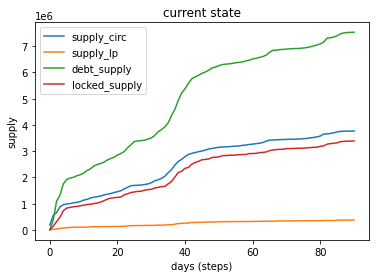

In [ ]:
# plot values
df_current.plot()
plt.xlabel("days (steps)")
plt.ylabel("supply")
plt.title("current state")
plt.show()

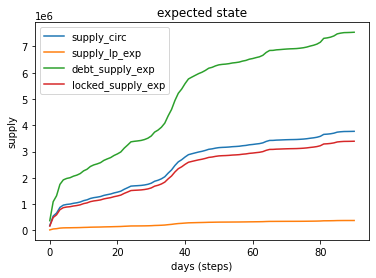

In [ ]:
df_exp.plot()
plt.xlabel("days (steps)")
plt.ylabel("supply")
plt.title("expected state")
plt.show()

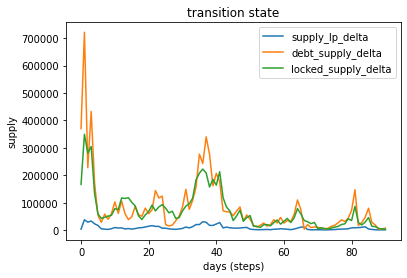

In [ ]:
# transition state tells us how close we are getting to reaching the expected state
df_transition.plot()
plt.xlabel("days (steps)")
plt.ylabel("supply")
plt.title("transition state")
plt.show()

## Monitoring Protocol Health

In [ ]:
current_lock_ratio = df_current['locked_supply'] / df_current['supply_circ']
exp_lock_ratio = df_exp['locked_supply_exp'] / df_exp['supply_circ']

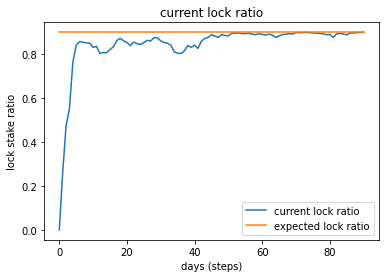

In [ ]:
current_lock_ratio.plot(label="current lock ratio")
exp_lock_ratio.plot(label="expected lock ratio")
plt.title("current lock ratio")
plt.xlabel("days (steps)")
plt.ylabel("lock stake ratio")
plt.legend()
plt.show()

In [ ]:
current_lp_ratio = df_current['supply_lp'] / df_current['supply_circ']
exp_lp_ratio = df_exp['supply_lp_exp'] / df_exp['supply_circ']

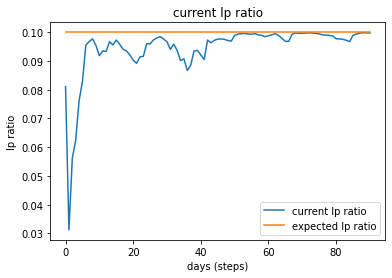

In [ ]:
current_lp_ratio.plot(label="current lp ratio")
exp_lp_ratio.plot(label="expected lp ratio")
plt.title("current lp ratio")
plt.xlabel("days (steps)")
plt.ylabel("lp ratio")
plt.legend()
plt.show()

# Resources / Inspiration

https://people.eecs.berkeley.edu/~ksk/files/Ohm_Liquidity_Management.pdf 
* Pro - thinks of liquidity management from a new point of view as a portfolio optimization problem.
* Con - shortfall in conceptual thinking, spends too much time explaining non-linear to linear transformation from theoretical point of view. 

http://hiperlab.berkeley.edu/wp-content/uploads/2018/05/2014_StabilityAndControlOfAQuadrocopterDespiteTheCompleteLossOfOneTwoOrThreePropellers.pdf 
* Quickly redstributes power to achieve stability when multiple propellers fail. This is essentially achieved by creating constrained functions around the minimum amount of power distribution to required to keep the quadrocopter flying. 
* Applies harmonic analysis on the physics of the quadrocopter to obtain an equilibrium function. Harmonic analysis is inherently symmetric as it deals with sin and cosine waves, which themselves are translation invariant. 

https://proceedings.neurips.cc/paper/2020/file/2be5f9c2e3620eb73c2972d7552b6cb5-Paper.pdf 
* https://www.youtube.com/watch?v=oGIdn5aU1_U 
  * https://simons.berkeley.edu/talks/Equivariant-RL
* Commutative Algebra applied to state of the art reinforcement learning, similar approach used for alphafold. 
* Exploits properties of symmetric group to improve training efficiency while less data.  

alphafold proteins - https://www.nature.com/articles/s41586-021-03819-2.pdf

controlling tokemak via RL - https://www.nature.com/articles/s41586-021-04301-9.pdf 

MPO (MAXIMUM A POSTERIORI POLICY OPTIMISATION, 2018)
* https://www.dropbox.com/s/pgcmjst7t0zwm4y/MPO.mp4 



https://www.sciencedirect.com/topics/mathematics/eigenfunction 